#Spark setup

In [ ]:
 # Install Spark 3.0.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
# Install findspark
!python -m pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
APP_NAME = "Capstone"
SPARK_URL = "local[*]"

In [ ]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [ ]:
spark

#Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Loading Kaggle data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!kaggle datasets download -d asaniczka/tmdb-movies-dataset-2023-930k-movies

Dataset URL: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
License(s): ODC Attribution License (ODC-By)
 95% 185M/195M [00:02<00:00, 94.9MB/s]
100% 195M/195M [00:02<00:00, 98.7MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tmdb-movies-dataset-2023-930k-movies.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#put csv into pandas dataframe
location = '/content/TMDB_movie_dataset_v11.csv'
TMDB_movie = pd.read_csv(location)
TMDB_movie.drop(columns=['backdrop_path', 'homepage', 'overview', 'poster_path', 'tagline'], inplace=True)

# Save the updated DataFrame back to the CSV file
TMDB_movie.to_csv(location, index=False)

TMDB_movie.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,popularity,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,tt1375666,en,Inception,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,tt0816692,en,Interstellar,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,tt0468569,en,The Dark Knight,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,tt0499549,en,Avatar,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,tt0848228,en,The Avengers,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, BooleanType

# Load the DataFrame with the explicit schema
spark_df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
spark_df.show(5)
spark_df.printSchema()

+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|          title|vote_average|vote_count|  status|release_date|   revenue|runtime|adult|   budget|  imdb_id|original_language| original_title|popularity|              genres|production_companies|production_countries|    spoken_languages|            keywords|
+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 27205|      Inception|       8.364|     34495|Released|  2010-07-15| 825532764|    148|False|160000000|tt1375666|               en|      Inception|    83.952|Action, Science F...|Legendary Picture...|

In [ ]:
from pyspark.sql.functions import to_date, col

#clean release date column
spark_df = spark_df.withColumn('Date_Released', to_date(col('release_date'), 'yyyy-MM-dd'))
spark_sorted = spark_df.sort(spark_df['Date_Released'].desc())
spark_dropped = spark_sorted.drop('release_date')
spark_dropped = spark_dropped.dropna(subset=['Date_Released'])
spark_dropped.show(5)

+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|     0|tt5174640|               en|           100 Years|     2.238|Drama, Science F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_vote_count = spark_dropped.filter(col('vote_count') == 0).count()
print(f"Number of rows where vote_count is 0: {zero_vote_count}")

Number of rows where vote_count is 0: 576457


In [ ]:
# Drop rows where vote_count is 0
#spark_dropped = spark_dropped.filter(col('vote_count') != 0)

# A true "movie" must be at least 75 minutes long?
#spark_dropped = spark_dropped.filter(col('runtime') >= 75)

spark_dropped = spark_dropped.dropna(subset=['Date_Released', 'imdb_id'])

spark_dropped.show(5)

from pyspark.sql.functions import count, when, min, max

# Print the number of rows
num_rows = spark_dropped.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(spark_dropped.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = spark_dropped.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_dropped.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in spark_dropped.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in spark_dropped.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|   budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|        0| tt5174640|               en|           100 Years|     2.238|Drama, Science Fi...|Troublemaker St

In [ ]:
import pyspark.sql.functions as F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_rev_count = spark_dropped.filter(col('revenue') == 0).count()
print(f"Number of rows where revenue_count is 0: {zero_rev_count}")

Number of rows where revenue_count is 0: 530554


In [ ]:
# Filter rows where vote_count is 0 and count them
zero_budg_count = spark_dropped.filter(col('budget') == 0).count()
print(f"Number of rows where budget_count is 0: {zero_budg_count}")

Number of rows where budget_count is 0: 512954


In [ ]:
#drop rows with revenue <= 1,000 & budge = 0
spark_rev = spark_dropped.filter((F.col('revenue').isNotNull()) & (F.col('revenue') > 0))
spark_budg = spark_rev.filter((F.col('budget').isNotNull()) & (F.col('budget') > 0))
spark_budg.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|        genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------+--------------------+--------------------+----------------+--------------------+-------------+
|1289915|El fin de todas l...|         0.0|         0|In Production|    100|      0|False|  1500|tt30955047|               es|El fin de todas l...|     1.186|Drama, Fantasy|SKY LAND Studios,...|Ar

In [ ]:
spark_budg.count()

10593

In [ ]:
from pyspark.sql.types import IntegerType, FloatType

#changing type to Integer
data_nums = spark_budg.withColumn("budget", F.col("budget").cast(IntegerType())) \
                .withColumn("revenue", F.col("revenue").cast(IntegerType())) \
                .withColumn("vote_average", F.col("vote_average").cast(FloatType())) \
                .withColumn("vote_count", F.col("vote_count").cast(IntegerType())) \
                .withColumn("runtime", F.col("runtime").cast(IntegerType())) \
                .withColumn("popularity", F.col("popularity").cast(FloatType()))
#varifying it worked
data_nums.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)



In [ ]:
#calculating profit with revenue and budget
profit = data_nums.withColumn('ProfitValue', data_nums.revenue - data_nums.budget)
profit.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|1289915|El fin de todas l...|         0.0|         0|In Production|    100|      0|False|  1500|tt30955047|               es|El fin de todas 

In [ ]:
#registering the table to SQL
profit.createOrReplaceTempView("profit")

#showing profit count of negative profits
spark.sql("SELECT count(ProfitValue) FROM profit where ProfitValue < 0" ).show()

+------------------+
|count(ProfitValue)|
+------------------+
|              3419|
+------------------+



In [ ]:
from pyspark.sql.functions import when

#create a classification column for Profit True or False
profit_class = profit.withColumn("Profit_TorF",when(profit.ProfitValue > 0, 1).when(profit.ProfitValue <= 0, 0).otherwise(2))
profit_class.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|        genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|1289915|El fin de todas l...|         0.0|         0|In Production|    100|      0|False|  1500|tt30955047|               e

In [ ]:
from pyspark.sql.functions import split

#Parse out year of release date
parsed_date = profit_class.withColumn('Year_Released', split(profit_class['Date_Released'], '-').getItem(0))
parsed_date.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|1289915|El fin de todas l...|         0.0|         0|In Product

In [ ]:

from pyspark.sql.types import IntegerType, FloatType

#changing year type to Integer
parsed_date = parsed_date.withColumn("Year_Released", F.col("Year_Released").cast(IntegerType()))

#varifying it worked
parsed_date.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)
 |-- ProfitValue: integer (nullable = true)
 |-- Profit_TorF: integer (nullable = false)
 |-- Year_Released: integer (nullable = true)



In [ ]:
parsed_date.count()

10593

In [ ]:
from pyspark.sql.functions import when

#Creating a covid classification column pre and post covid
movie_classified = parsed_date.withColumn("Covid",when(parsed_date.Year_Released > 2019, 'Post').when(parsed_date.Year_Released <= 2019, 'Pre').otherwise('covid unknown'))
movie_classified.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|1289915|El fin de todas l...|         0.0|   

In [ ]:
import requests
import gzip
import shutil
import pandas as pd
import numpy as np

# URL for the IMDB Non-Commercial Crew Members Dataset
url = 'https://datasets.imdbws.com/title.crew.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'title.crew.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('title.crew.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
title_crew = pd.read_csv('title.crew.tsv', delimiter='\t', low_memory=False)

# Display the DataFrame
title_crew.dtypes
title_crew['directors'] = title_crew['directors'].astype(str)
title_crew['first_director'] = title_crew['directors'].apply(lambda x: x.split(',')[0])
title_crew.drop(columns=['directors', 'writers'],axis=1, inplace=True)
title_crew.head()


,tconst,first_director
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690


In [ ]:
import requests
import gzip
import shutil
import pandas as pd

# URL for the IMDB Non-Commercial Person Dataset
url = 'https://datasets.imdbws.com/name.basics.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'name.basics.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('name.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t', low_memory=False)
name_basics.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Display the DataFrame
print(name_basics.head())


      nconst      primaryName                   primaryProfession  \
0  nm0000001     Fred Astaire        actor,miscellaneous,producer   
1  nm0000002    Lauren Bacall  actress,soundtrack,archive_footage   
2  nm0000003  Brigitte Bardot   actress,music_department,producer   
3  nm0000004     John Belushi       actor,writer,music_department   
4  nm0000005   Ingmar Bergman               writer,director,actor   

                            knownForTitles  
0  tt0072308,tt0050419,tt0053137,tt0027125  
1  tt0037382,tt0075213,tt0117057,tt0038355  
2  tt0057345,tt0049189,tt0056404,tt0054452  
3  tt0072562,tt0077975,tt0080455,tt0078723  
4  tt0050986,tt0083922,tt0050976,tt0069467  


In [ ]:
director = pd.merge(title_crew, name_basics, left_on='first_director', right_on='nconst', how='inner')
director.drop(columns=['nconst', 'first_director'], axis=1, inplace=True)
director.to_csv('/content/director.csv', index=False)

director_sdf = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/director.csv')
director_sdf.show(5)

+---------+--------------------+--------------------+--------------------+
|   tconst|         primaryName|   primaryProfession|      knownForTitles|
+---------+--------------------+--------------------+--------------------+
|tt0000001|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000005|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000006|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000007|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000008|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
movie_classified = movie_classified.join(director_sdf, movie_classified.imdb_id==director_sdf.tconst, how='left')
movie_classified = movie_classified.withColumnRenamed('primaryName', 'Director')
movie_classified = movie_classified.drop('tconst')
movie_classified.show(5)

+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+-----------+-----------+-------------+-----+---------------+--------------------+--------------------+
|    id|               title|vote_average|vote_count|  status|  revenue|runtime|adult| budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|  spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|       Director|   primaryProfession|      knownForTitles|
+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+----------------

In [ ]:
from pyspark.sql.functions import col, count, when, min, max

# Print the number of rows
num_rows = movie_classified.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(movie_classified.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = movie_classified.select([count(when(col(c).isNull(), c)).alias(c) for c in movie_classified.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in movie_classified.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in movie_classified.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

print("\nTotal number of Numerical Columns in the dataset:",len(numerical_cols))
#for col_name in numerical_cols:
#    print(f"{col_name}:")

print("\nCategorical Columns:")
for col_name in categorical_cols:
    print(f"{col_name}:")

# Summary Notes about the Dataset
print("\nDataset Summary:")
movie_classified.summary().show()

Number of rows: 10593
Number of columns: 26
Null Counts in Each Column:
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
| id|title|vote_average|vote_count|status|revenue|runtime|adult|budget|imdb_id|original_language|original_title|popularity|genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|Director|primaryProfession|knownForTitles|
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
|  0|    0|           0|       

In [ ]:
#registering the table to SQL
movie_classified.createOrReplaceTempView("movie_classified")

#showing profit count of negative profits
spark.sql("Select y.Covid, (y.profit_yes/t.total_profit) as avg_profit_count from (Select Covid, count(Profit_TorF) as profit_yes FROM movie_classified where Profit_TorF = 1 group by Covid) as y Join (Select Covid, count(Profit_TorF) as total_profit FROM movie_classified group by Covid) as t where y.Covid = t.Covid").show()


+-----+------------------+
|Covid|  avg_profit_count|
+-----+------------------+
|  Pre| 0.655705996131528|
| Post|0.5064935064935064|
+-----+------------------+



In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
data = movie_classified.toPandas()

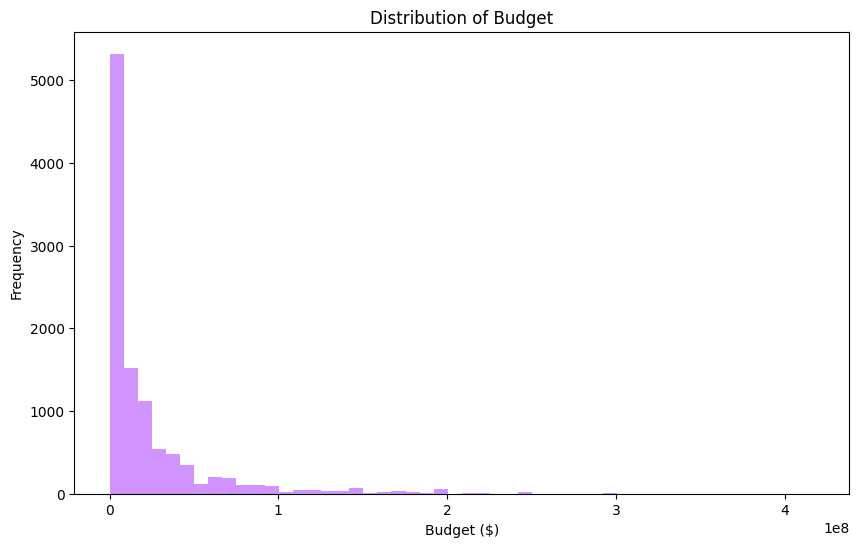

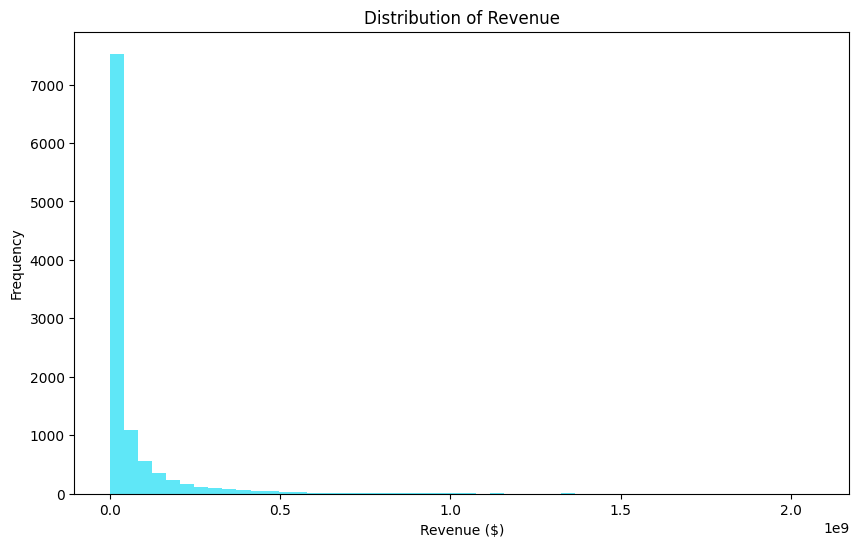

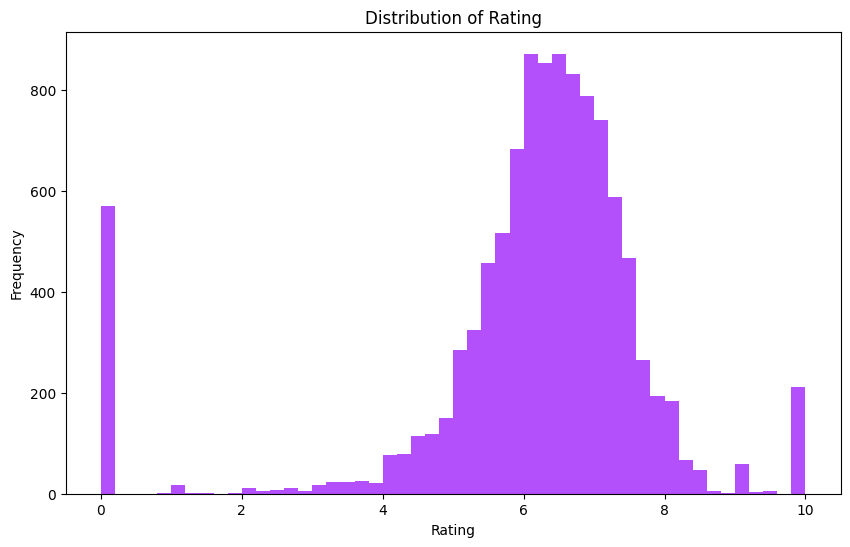

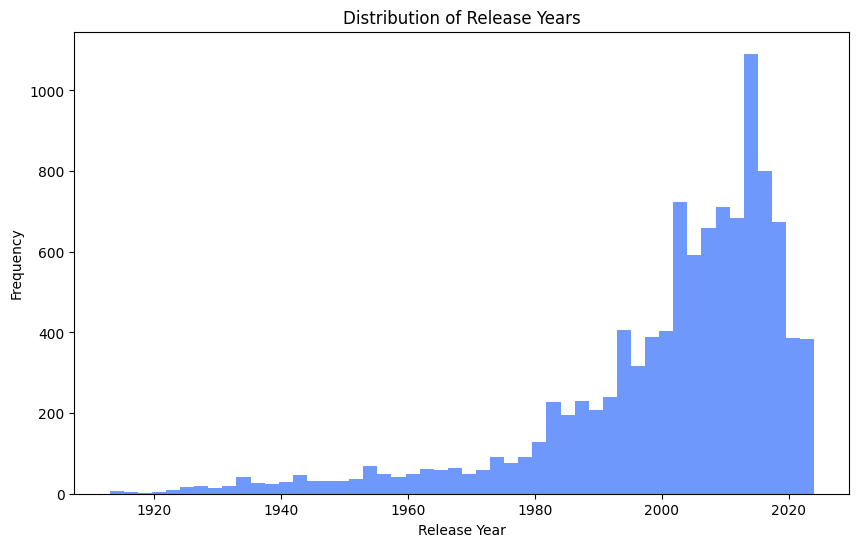

In [ ]:
# Budget Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['budget'], bins=50, color='#be67fe', alpha=0.7)
plt.title('Distribution of Budget')
plt.xlabel('Budget ($)')
plt.ylabel('Frequency')
plt.show()

# Revenue Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['revenue'], bins=50, color='#1bdef5', alpha=0.7)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.show()

# Rating Distribtion
plt.figure(figsize=(10, 6))
plt.hist(data['vote_average'], bins=50, color='#9405fc', alpha=0.7)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Release Year Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['Year_Released'], bins=50, color='#316cfc', alpha=0.7)
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()


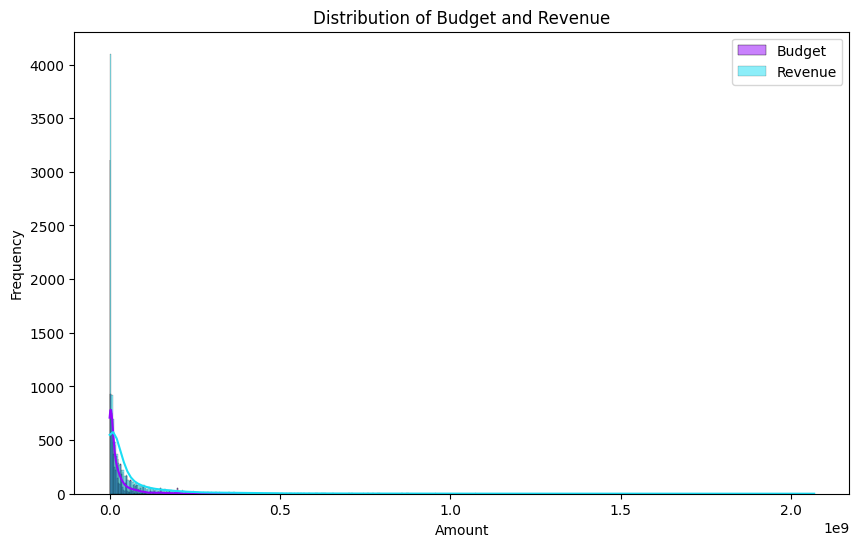

In [ ]:
# Budget vs revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['budget'], color='#9405fc', kde=True, label='Budget')
sns.histplot(data['revenue'], color='#1bdef5', kde=True, label='Revenue')
plt.title('Distribution of Budget and Revenue')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

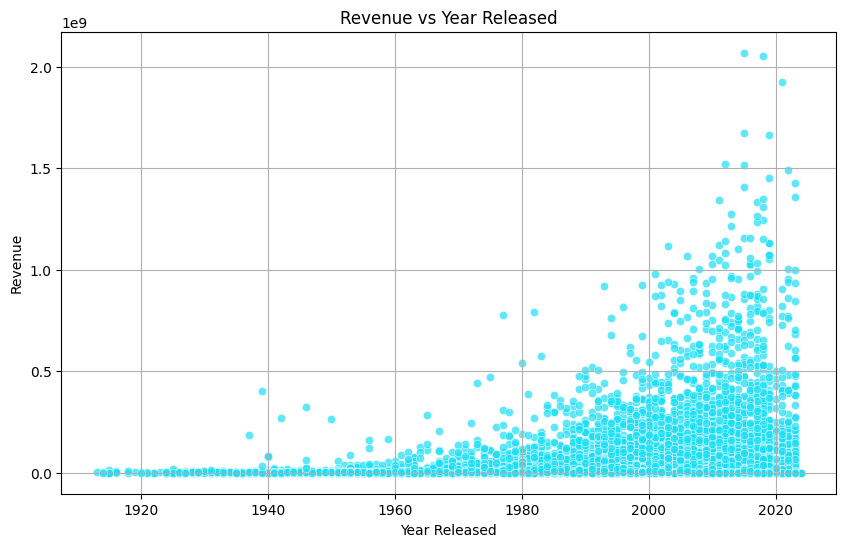

In [ ]:
#Release year and revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year_Released', y='revenue', data=data, color='#1bdef5', alpha=0.7)
plt.title('Revenue vs Year Released')
plt.xlabel('Year Released')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

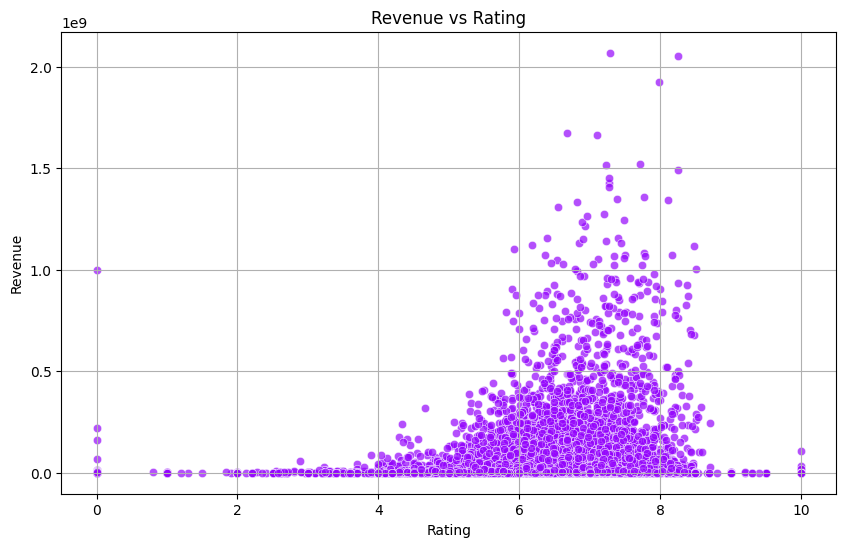

In [ ]:
#Revenue and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='revenue', data=data, color='#9405fc', alpha=0.7)
plt.title('Revenue vs Rating')
plt.xlabel('Rating')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

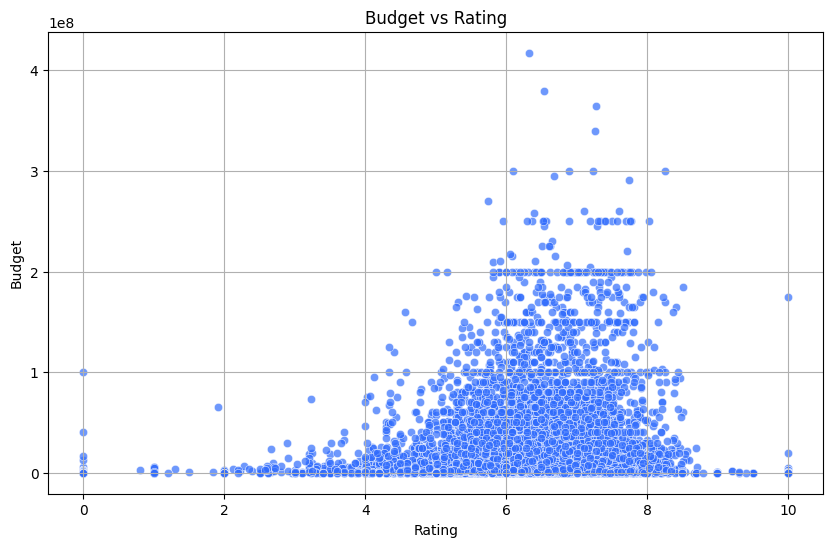

In [ ]:
#Budget and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='budget', data=data, color='#316cfc', alpha=0.7)
plt.title('Budget vs Rating')
plt.xlabel('Rating')
plt.ylabel('Budget')
plt.grid(True)
plt.show()

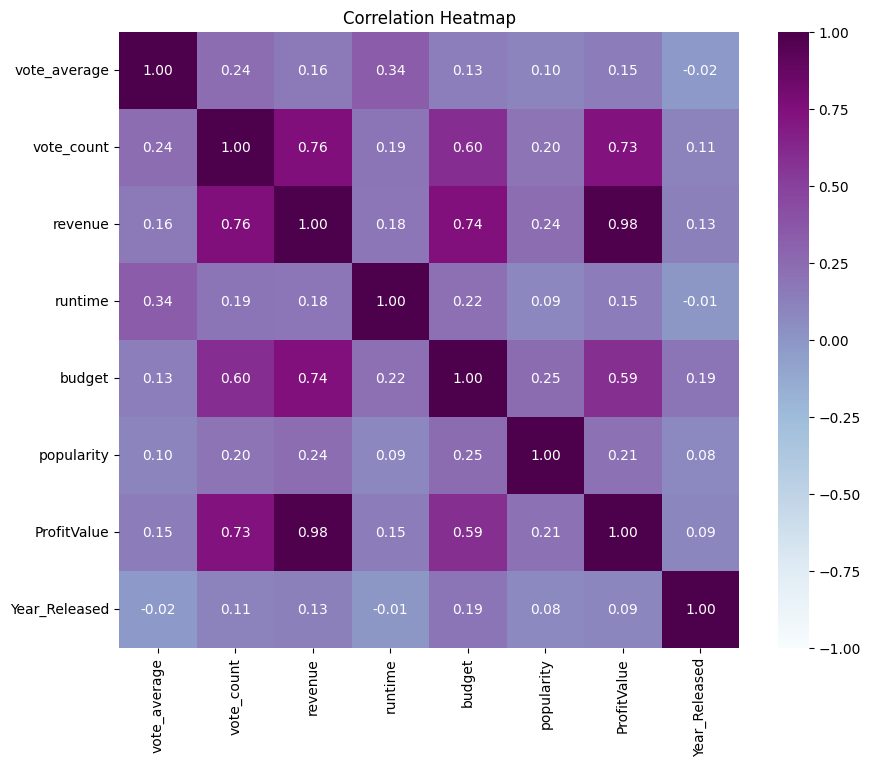

In [ ]:
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Year_Released']

# Correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

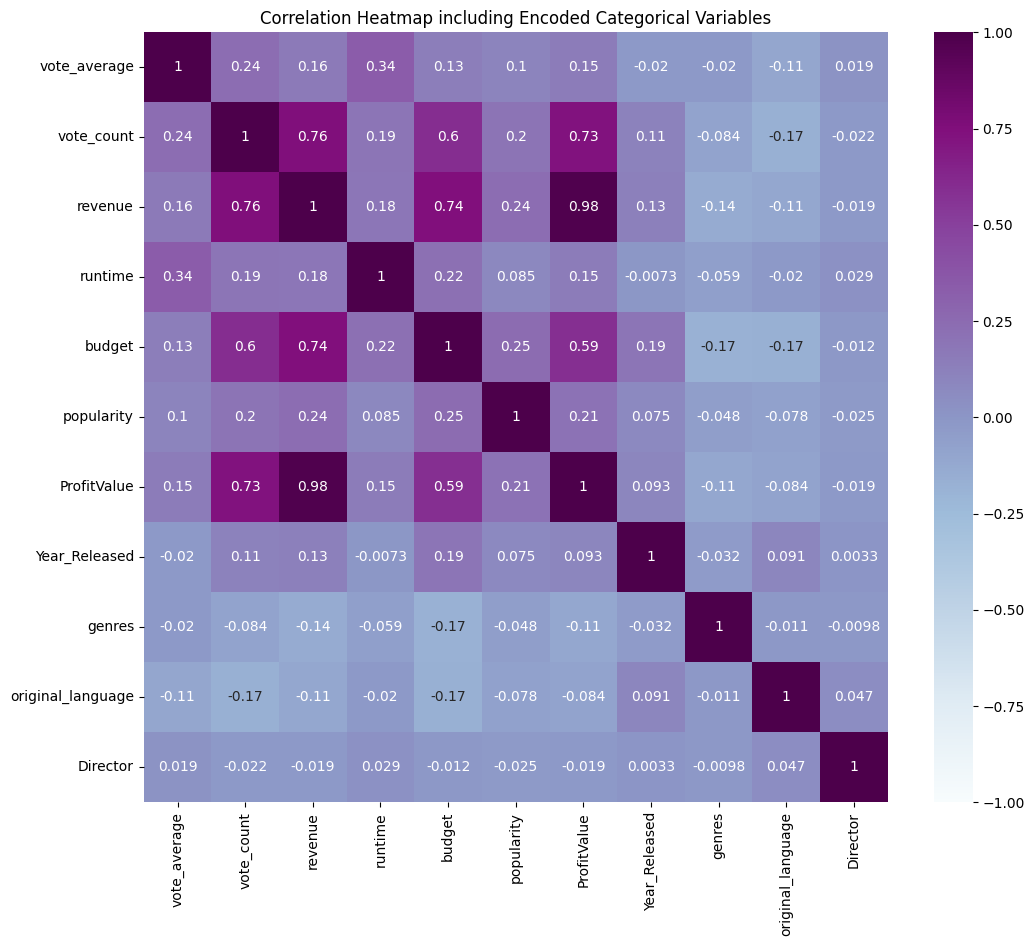

In [ ]:
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Year_Released']
categorical_columns = ['genres', 'original_language', 'Director']

#Copy of the DF with selected columns
df_encoded = data[numerical_columns + categorical_columns].copy()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform categorical columns
df_encoded[categorical_columns] = ordinal_encoder.fit_transform(df_encoded[categorical_columns])

# Correlation matrix
corr_matrix = df_encoded.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap including Encoded Categorical Variables')
plt.show()